# Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer, StandardScaler

import torch
from torch import nn

from dp_wgan import Generator, Discriminator
from dp_autoencoder import Autoencoder
from evaluation import *
import dp_optimizer, sampling, analysis, evaluation

torch.manual_seed(0)
np.random.seed(0)

### Checking out the data

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train = pd.read_csv('adult.data', names=names)
test = pd.read_csv('adult.test', names=names)

df = pd.concat([train, test])

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


The processor class pre- and post-processes the data

In [13]:
class Processor:
    def __init__(self, datatypes):
        self.datatypes = datatypes
        
    def fit(self, matrix):
        preprocessors, cutoffs = [], []
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)

            if 'categorical' in datatype:
                preprocessor = LabelBinarizer()
            else:
                preprocessor = MinMaxScaler()

            preprocessed_col = preprocessor.fit_transform(preprocessed_col)
            cutoffs.append(preprocessed_col.shape[1])
            preprocessors.append(preprocessor)
        
        self.cutoffs = cutoffs
        self.preprocessors = preprocessors
    
    def transform(self, matrix):
        preprocessed_cols = []
        
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)
            preprocessed_col = self.preprocessors[i].transform(preprocessed_col)
            preprocessed_cols.append(preprocessed_col)

        return np.concatenate(preprocessed_cols, axis=1)

        
    def fit_transform(self, matrix):
        self.fit(matrix)
        return self.transform(matrix)
            
    def inverse_transform(self, matrix):
        postprocessed_cols = []

        j = 0
        for i, (column, datatype) in enumerate(self.datatypes):
            postprocessed_col = self.preprocessors[i].inverse_transform(matrix[:,j:j+self.cutoffs[i]])

            if datatype == 'categorical':
                postprocessed_col = postprocessed_col.reshape(-1, 1)
            else:
                if 'positive' in datatype:
                    postprocessed_col = postprocessed_col.clip(min=0)

                if 'int' in datatype:
                    postprocessed_col = postprocessed_col.round()

            postprocessed_cols.append(postprocessed_col)
            
            j += self.cutoffs[i]
        
        return np.concatenate(postprocessed_cols, axis=1)


datatypes = [
    ('age', 'positive int'),
    ('workclass', 'categorical'),
    ('education-num', 'categorical'),
    ('marital-status', 'categorical'),
    ('occupation', 'categorical'),
    ('relationship', 'categorical'),
    ('race', 'categorical'),
    ('sex', 'categorical'),
    ('capital-gain', 'positive float'),
    ('capital-loss', 'positive float'),
    ('hours-per-week', 'positive int'),
    ('native-country', 'categorical'),
    ('salary', 'categorical'),
]

### Preprocessing the input ground-truth data

In [14]:
processor = Processor(datatypes)

relevant_df = df.drop(columns=['education', 'fnlwgt'])
for column, datatype in datatypes:
    if datatype == 'categorical':
        relevant_df[column] = relevant_df[column].astype('category').cat.codes

X_real = torch.tensor(relevant_df.to_numpy(dtype=np.float32).astype('float32'))
X_encoded = torch.tensor(processor.fit_transform(X_real).astype('float32'))

train_cutoff = 32562

X_train_real = X_real[:train_cutoff]
X_test_real = X_real[:train_cutoff]

X_train_encoded = X_encoded[:train_cutoff]
X_test_encoded = X_encoded[train_cutoff:]

print(X_train_encoded)
print(X_test_encoded)

tensor([[0.3014, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4521, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0685, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.1096, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1507, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.3699, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3699, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2466, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


### Defining the parameters we used for the autoencoder and the generator

Reading data from the file

In [23]:
X_synthetic_encoded = pd.read_csv('chris_synth.csv').drop(columns=['Unnamed: 0']).to_numpy()

Using Tao's PCA function

In [24]:
def std_PCA(W,d):
    '''
    Given a n x n matrix (this is equal to A^T A for an m x n data matrix A), output the top d eigenvectors of W as numpy n x d matrix.
    '''
    [eigenValues,eigenVectors] = np.linalg.eig(W)

    #sort eigenvalues and eigenvectors in decending orders
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    #take the first d vectors. Obtained the solution
    return eigenVectors[:,:d]

In [36]:
mask = np.random.choice([False, True], X_train_encoded.numpy().shape[0], p=[0.17, 0.83])

1. Take the dataset and normalize to mean 0.
1. Find the PCA in 2 dimensions
1. Use eigenvectors to apply onto real and synthetic datasets

In [55]:
pca_basis = pd.DataFrame(X_train_encoded.numpy()[mask])
pca_real = ((pca_basis - pca_basis.mean())/pca_basis.std()).fillna(0)

pca_synth = ((pd.DataFrame(X_synthetic_encoded) - pca_basis.mean())/pca_basis.std()).fillna(0)

eigen_vectors = std_PCA((pca_real.to_numpy().T @ pca_real.to_numpy()), 2)

proj_real_real = pd.DataFrame(np.matmul(pca_real.to_numpy(), eigen_vectors))
proj_synth_real = pd.DataFrame(np.matmul(pca_synth.to_numpy(), eigen_vectors))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':


Save the PCA of real dataset

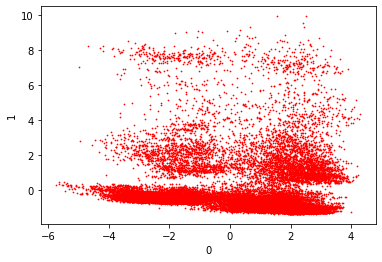

In [56]:
proj_real_real.to_csv('')
proj_real_real.plot(x = 0, y = 1, c ='red', kind = 'scatter', s =0.5)

Save the PCA of synthetic dataset

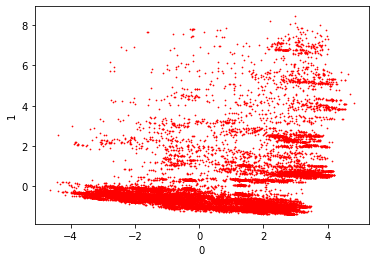

In [57]:
proj_synth_real.to_csv('')
proj_synth_real.plot(x = 0, y = 1, c ='red', kind = 'scatter', s =0.5)